In [1]:
import os, sys, ROOT                                                    
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

#IMPORTANT: THIS NOTEBOOK SHOULD BE READ ONCE, THEN RESTART THE KERNEL.

Welcome to JupyROOT 6.08/06


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data.dataloader as dataloader


from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

from mpid_data import mpid_data
from mpid_net import mpid_net, mpid_func
from __future__ import print_function
from larcv import larcv
larcv.LArbysLoader()
import cv2
from larcv_projection_helper import utility as u


In [3]:
torch.cuda.is_available()

True

# SETUP MPID

In [4]:
from lib.config import config_loader
MPID_PATH = os.path.dirname(mpid_data.__file__)+"/../cfg"
CFG = os.path.join(MPID_PATH,"inference_config.cfg")

# CFG = os.path.join("../../cfg","inference_config.cfg")
cfg  = config_loader(CFG)

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]=cfg.GPUID

self.adc_lo=float(10)
self.adc_hi=float(500)
self.augment=False
self.batch_size_train=int(1)
self.batch_size_test=int(1)
self.drop_out=0.0
self.EPOCHS=50
self.GPUID=str("1")
self.learning_rate=float(1e-3)
self.name=str("BN_False_LR-3_AG_True")
self.num_class=int(5)
self.plane=2
self.run_test=True
self.test_events_nums=9
self.test_every_step=10
self.weight_file_mpid_0=str("/scratch/ruian/training_data/weights/pid/plane0/pid-245199")
self.weight_file_mpid_1=str("/scratch/ruian/training_data/weights/pid/plane1/pid-355199")
self.weight_file_mpid_2=str("/scratch/ruian/training_data/weights/pid/plane2/pid-453799")
self.xdim=int(512)
self.ydim=int(512)


In [5]:
ls()

/bin/sh: 1: Syntax error: "(" unexpected


## Load MPID weights

In [6]:
weight_file = 'mpid_model_20200901-09_45_PM_epoch_31_batch_id_561_labels_2_title_0.001_AG_GN_final_step_19750.pwf'

In [7]:
train_device = 'cuda' if torch.cuda.is_available() else 'cpu'

mpid = mpid_net.MPID()
mpid.cuda()

mpid.load_state_dict(torch.load(weight_file, map_location=train_device))

mpid.eval()

MPID(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): GroupNorm(64, 64, eps=1e-05, affine=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): GroupNorm(64, 64, eps=1e-05, affine=True)
    (6): AvgPool2d(kernel_size=2, stride=2, padding=1)
    (7): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): GroupNorm(96, 96, eps=1e-05, affine=True)
    (10): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1))
    (11): ReLU()
    (12): GroupNorm(96, 96, eps=1e-05, affine=True)
    (13): AvgPool2d(kernel_size=2, stride=2, padding=1)
    (14): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU()
    (16): GroupNorm(128, 128, eps=1e-05, affine=True)
    (17): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (18): ReLU()
    (19): GroupNorm(128, 128, eps=1e-05, affine=True)
    (20): AvgPool2d(kernel_size=2, str

# One event test 

The following lines, will read the vertex and dm info list, then it will find the 3D projection into the selected 2D plane (tipically induction)

In [8]:
#Global variables
entry = 10
plane = 2

In [9]:
iom = larcv.IOManager(larcv.IOManager.kREAD)
iom.add_in_file("../MPID/input/dm_sample01.root")
iom.initialize()

True

    [NORMAL]  <IOManager::prepare_input> Opening a file in READ mode: ../MPID/input/dm_sample01.root
    [NORMAL]  <IOManager::initialize> Prepared input with 1380 entries...


Warning in <TClass::Init>: no dictionary for class ROOT::TIOFeatures is available
Warning in <TClass::Init>: no dictionary for class larcv::EventSparseImage is available
Warning in <TClass::Init>: no dictionary for class larcv::SparseImage is available
Warning in <TClass::Init>: no dictionary for class larcv::EventClusterMask is available


In [10]:
# Access entry
iom.read_entry(entry)
# Access a product instance (type,label) = (image2d,data)
image2d_data = iom.get_data(larcv.kProductImage2D,"wire")
print("Retrieved data snapshot",image2d_data)

Retrieved data snapshot <ROOT.larcv::EventImage2D object at 0xbb9b130>


In [11]:
#print("Run, sub-run, event: ", image2d_data.run(), image2d_data.subrun(),image2d_data.event())

In [12]:
run_vertex = image2d_data.run()
subrun_vertex = image2d_data.subrun()
event_vertex = image2d_data.event()

In [13]:
#df = pd.read_csv("dm_vertex_v3.csv")
#di = pd.read_csv("dm_info_v3.csv")

df = pd.read_csv("dm_vertex.csv")
di = pd.read_csv("dm_info.csv")

In [14]:
index_array = di.query('run == {:2d} & subrun == {:2d} & event == {:2d}'.format(run_vertex,subrun_vertex,event_vertex)).index.values

/usr/local/lib/python2.7/dist-packages/pandas/core/computation/check.py:19: UserWarning: The installed version of numexpr 2.4.3 is not supported in pandas and will be not be used
The minimum supported version is 2.6.1

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


In [15]:
print('run == {:2d} & subrun == {:2d} & event == {:2d}'.format(run_vertex,subrun_vertex,event_vertex))

run ==  1 & subrun == 15 & event == 11


In [16]:
vertex_index = index_array[0]

In [17]:
x_2d = ROOT.Double()
y_2d = ROOT.Double()

vx , vy ,vz = df['v_x'][vertex_index], df['v_y'][vertex_index], df['v_z'][vertex_index]
print(vx,vy,vz)

119.977 40.2439 163.02100000000002


In [18]:
whole_img = image2d_data.at(plane)
whole_image=larcv.as_ndarray(whole_img)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:2: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  from ipykernel import kernelapp as app


In [19]:
whole_image.shape

(3456, 1008)

In [20]:
whole_img.reset_origin(0, 8448)

In [21]:
larcv.Project3D(whole_img.meta(), vx, vy, vz, 0, plane , x_2d, y_2d)
#Print project 2d vertex at selected plane
print(x_2d , y_2d)

    [NORMAL]  <LoadData> Loading data for Geometry...
     file=/usr/local/share/dllee_unified/larlite/core/LArUtil/dat/larutil_microboone.root 
    [NORMAL]  <LoadData> Loading data for DetectorProperties...
     file=/usr/local/share/dllee_unified/larlite/core/LArUtil/dat/larutil_microboone.root 
    [NORMAL]  <LoadData> Loading data for LArProperties...
     file=/usr/local/share/dllee_unified/larlite/core/LArUtil/dat/larutil_microboone.root 
543.069986979 492.215331041


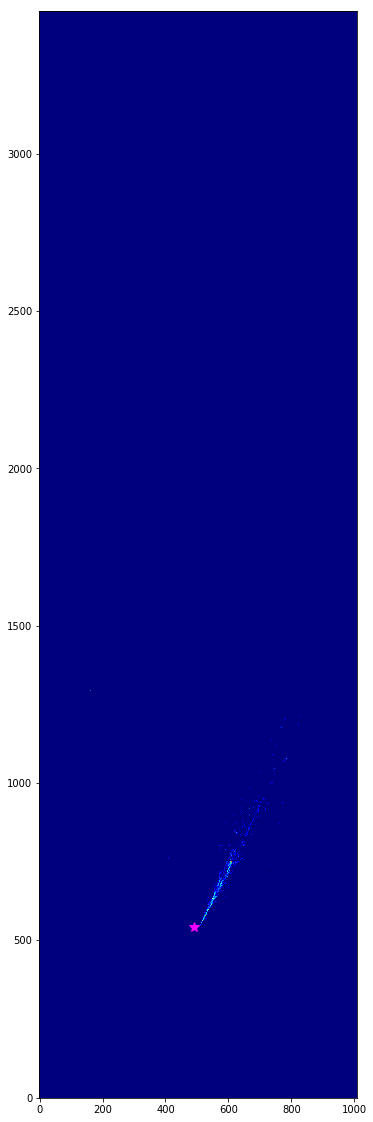

In [22]:
fig, ax1 = plt.subplots(1,1,figsize=(20,20))
ax1.imshow(whole_image, cmap="jet", origin="lower")
ax1.plot(y_2d, x_2d, "*", markersize=10, color="magenta")

In [23]:
meta_crop = larcv.ImageMeta(512,512*6,512,512,0,0,plane)
meta_origin_x, meta_origin_y = u.Meta_origin_helper(x_2d, y_2d, verbose=0)
print(meta_origin_x,meta_origin_y)
meta_crop.reset_origin(meta_origin_x,meta_origin_y)
image_vtx = image2d_data.at(plane).crop(meta_crop)
img_vtx = larcv.as_ndarray(image_vtx)
img_vtx = np.where(img_vtx<10 ,0  ,img_vtx)
img_vtx = np.where(img_vtx>500,500,img_vtx)

287.069986979 7030.70801375


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:6: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.


# Start inference 

In [24]:
img_input = torch.from_numpy(img_vtx.copy()).view(-1,1,512,512)
score = nn.Sigmoid()(mpid(img_input.cuda())).cpu().detach().numpy()[0]

In [25]:
print(score)

[0.00326544 0.9968273 ]


Text(0,120,'Entry, 10')

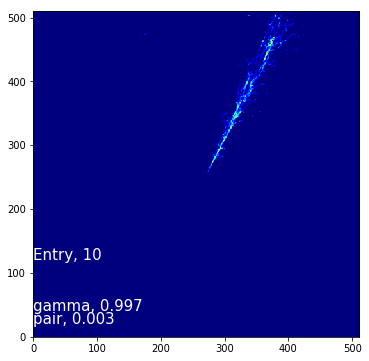

In [26]:
fig, ax= plt.subplots(1,1,figsize=(7,6))
ax.imshow(img_vtx, cmap="jet", origin="lower")
ax.set_xlim(0,511)
ax.set_ylim(0,511)
ax.text(0,20, "pair, %.3f"%score[0],color="white",fontsize=15)
ax.text(0,40, "gamma, %.3f"%score[1],color="white",fontsize=15)
ax.text(0,120, "Entry, %i"%entry,color="white",fontsize=15)

In [27]:
"""
fig, ax= plt.subplots(1,1,figsize=(7,6))
ax.imshow(img_vtx, cmap="jet", origin="lower")
ax.set_xlim(0,511)
ax.set_ylim(0,511)
ax.text(0,20, "electron, %.3f"%score[0],color="white",fontsize=15)
ax.text(0,40, "gamma, %.3f"%score[1],color="white",fontsize=15)
ax.text(0,60, "muon, %.3f"%score[2],color="white",fontsize=15)
ax.text(0,80, "pion, %.3f"%score[3],color="white",fontsize=15)
ax.text(0,100, "proton, %.3f"%score[4],color="white",fontsize=15)
ax.text(0,120, "e+e- pair, %.3f"%score[5],color="white",fontsize=15)
#ax.text(0,120, "Entry, %i"%entry,color="white",fontsize=15)
"""


'\nfig, ax= plt.subplots(1,1,figsize=(7,6))\nax.imshow(img_vtx, cmap="jet", origin="lower")\nax.set_xlim(0,511)\nax.set_ylim(0,511)\nax.text(0,20, "electron, %.3f"%score[0],color="white",fontsize=15)\nax.text(0,40, "gamma, %.3f"%score[1],color="white",fontsize=15)\nax.text(0,60, "muon, %.3f"%score[2],color="white",fontsize=15)\nax.text(0,80, "pion, %.3f"%score[3],color="white",fontsize=15)\nax.text(0,100, "proton, %.3f"%score[4],color="white",fontsize=15)\nax.text(0,120, "e+e- pair, %.3f"%score[5],color="white",fontsize=15)\n#ax.text(0,120, "Entry, %i"%entry,color="white",fontsize=15)\n'